### Dataset and Model

We'll train an MLP to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist) to demonstrate the effect of different initial weights. The FashionMNIST dataset contains images of clothing types; `classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']`. The images are normalized so that their pixel values are in a range [0.0 - 1.0).

### Import Libraries and Load [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import copy

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize Some Training Data

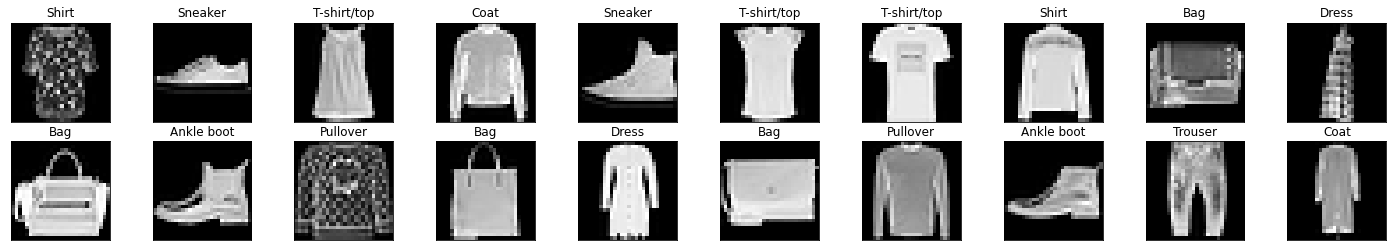

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## Define the Model Architecture

We've defined the MLP that we'll use for classifying the dataset.

### Neural Network
<img style="float: left" src="neural_net.png" width=50%/>


* A 3 layer MLP with hidden dimensions of 256 and 128. 

* This MLP accepts a flattened image (784-value long vector) as input and produces 10 class scores as output.
---
We'll test the effect of different initial weights on this 3 layer neural network with ReLU activations and an Adam optimizer.

### Note:
Declaring model in a function, because backprop step (in get_loss_acc()) updates weights in original model also.
Only a reference/pointer is created when you copy a model to new variable.
Even deepcopy, does not help during backpropagation.

In [4]:
def model_func():
    model = nn.Sequential(nn.Linear(28*28,256),
                         nn.ReLU(),
                         nn.Dropout(p=0.2),
                         nn.Linear(256,128),
                         nn.ReLU(),
                         nn.Dropout(p=0.2),
                         nn.Linear(128,10))
    return model

# Function to Initialize weights

>#### `Considering 7 different cases of weight initialization`
>```
Choose 1 : Initialilize all 0s
Choose 2 : Initialize all 1s
Choose 3 : Weights from Uniform Distribution, Range(0,1)
Choose 4 : Weights from Uniform Distribution, Range(-.5,.5)
Choose 5 : Weights from Uniform Distribution, Range(-1/√n,1/√n); n - input to the node
Choose 6 : Weights from Normal Distribution, Range(-1/√n,1/√n); n - input to the node
Choose 7 : Auto Initialization (No explicit initialization); directly call model_func()


In [5]:
def weight_updater(model,choice):
    
#     if choice == 7:                                                      #Auto Initialization
#         return model_func()
    
    for name, param in model.named_parameters():
        
        if name.split(".")[1] == 'weight':
            weight_dict = {1:torch.zeros(param.size()),
                           2:torch.ones(param.size()),
                           3:torch.empty(param.size()).uniform_(0, 1),
                           4:torch.empty(param.size()).uniform_(-.5, .5),
                           5:torch.empty(param.size()).uniform_(-1/(param.size()[1])**.5, 1/(param.size()[1])**.5),
                           6:torch.empty(param.size()).normal_(mean=0,std=1/(param.size()[1])**.5)}
            
            model[int(name[0])].weight.data = weight_dict[choice]
            
        elif name.split(".")[1] == 'bias':
            model[int(name[0])].bias.data = torch.zeros(param.size())     #update bias to 0 always
            
    return model

Alternatively, below functions can be used for different cases of weight initialization

>#### `Update Constant Weights`
>```
def constant_weight_updater(model,constant_weight):
    for m in model.modules():
        if isinstance(m, nn.Linear):           #check if m is instance of nn.Linear
            nn.init.constant_(m.weight, constant_weight)
            nn.init.constant_(m.bias, 0)
    return model


>#### `Update Weights from Uniform Distribution`
>```
def uniform_weight_updater(model):
    for m in model.modules():                  
        if isinstance(m, nn.Linear):           #check if m is instance of nn.Linear
            m.weight.data.uniform_(0.0, 1.0)   #change the range of distribution (-.5,.5) or (-1/(m.in_features)**.5, 1/(m.in_features)**.5)
            m.bias.data.fill_(0)               #nn.init.constant_(m.bias, 0)
    return model

>#### `Update Weights from Normal Distribution`
>```
def normal_weight_updater(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):           #check if m is instance of nn.Linear
            m.weight.data.normal_(0., 1/(m.in_features)**.5)
            m.bias.data.fill_(0)               #nn.init.constant_(m.bias, 0)
    return model
    


# Train the network

In [6]:
def get_loss_acc(model, train_loader, valid_loader):
    """
    Get losses and validation accuracy of example neural network
    """
    n_epochs = 2
    learning_rate = 0.001
    
    # Training loss
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    # Measurements used for graphing loss
    loss_batch = []

    for epoch in range(1, n_epochs+1):
        # initialize var to monitor training loss
        train_loss = 0.0
        ###################
        # train the model #
        ###################
        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # flatten the input images
            data = data.view(len(data),-1)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record average batch loss 
            loss_batch.append(loss.item())
             
    # after training for 2 epochs, check validation accuracy 
    correct = 0
    total = 0
    for data, target in valid_loader:
        # flatten the input images
        data = data.view(len(data),-1)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # get the predicted class from the maximum class score
        _, predicted = torch.max(output.data, 1)
        # count up total number of correct labels
        # for which the predicted and true labels are equal
        total += target.size(0)
        correct += (predicted == target).sum()
      
    # calculate the accuracy
    # to convert `correct` from a Tensor into a scalar, use .item()
    valid_acc = correct.item() / total

    # return model stats
    return loss_batch, valid_acc

### Compare Model Behavior

Below, we are using `compare_init_weights` to compare the training and validation loss for different models we defined above.  This function takes in a list of models (each with different initial weights), the name of the plot to produce, and the training and validation dataset loaders. For each given model, it will plot the training loss for the first 100 batches and print out the validation accuracy after 2 training epochs.

In [7]:
def compare_init_weights(
        model_list,
        plot_title,
        train_loader,
        valid_loader,
        plot_n_batches=100):
    """
    Plot loss and print stats of weights using an example neural network
    """
    colors = ['b', 'r', 'g', 'c', 'y', 'k','m']
    label_accs = []
    label_loss = []

    assert len(model_list) <= len(colors), 'Too many initial weights to plot'

    for i, (model, label) in enumerate(model_list):
        loss, val_acc = get_loss_acc(model, train_loader, valid_loader)

        plt.plot(loss[:plot_n_batches], colors[i], label=label)
        label_accs.append((label, val_acc))
        label_loss.append((label, loss[-1]))

    plt.title(plot_title)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    print('After 2 Epochs:')
    print('Validation Accuracy')
    for label, val_acc in label_accs:
        print('  {:7.3f}% -- {}'.format(val_acc*100, label))
    print('Training Loss')
    for label, loss in label_loss:
        print('  {:7.3f}  -- {}'.format(loss, label))

### Model 1 - All Zeros

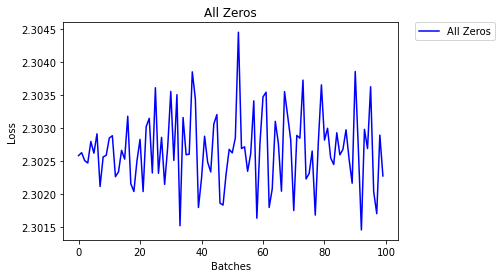

After 2 Epochs:
Validation Accuracy
    9.492% -- All Zeros
Training Loss
    2.302  -- All Zeros


In [8]:
compare_init_weights([(weight_updater(model_func(),1), 'All Zeros')],
                     'All Zeros',
                     train_loader,
                     valid_loader)

### Model 2 - All Ones

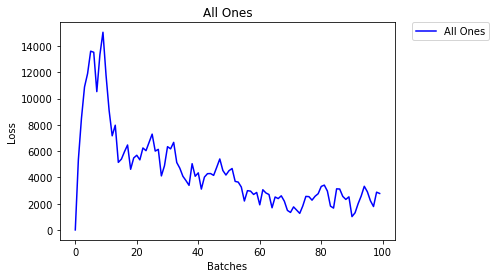

After 2 Epochs:
Validation Accuracy
   10.025% -- All Ones
Training Loss
  317.635  -- All Ones


In [9]:
compare_init_weights([(weight_updater(model_func(),2), 'All Ones')],
                     'All Ones',
                     train_loader,
                     valid_loader)

### Model 3 - Uniform Distribution [0,1]

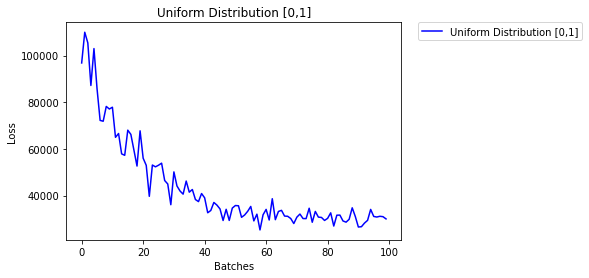

After 2 Epochs:
Validation Accuracy
   32.817% -- Uniform Distribution [0,1]
Training Loss
    8.095  -- Uniform Distribution [0,1]


In [10]:
compare_init_weights([(weight_updater(model_func(),3), 'Uniform Distribution [0,1]')],
                     'Uniform Distribution [0,1]',
                     train_loader,
                     valid_loader)

### Model 4 - Uniform Distribution  [-.5,.5]

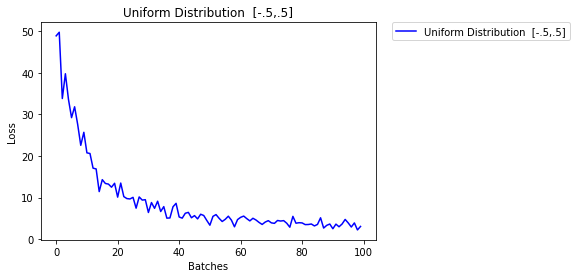

After 2 Epochs:
Validation Accuracy
   76.642% -- Uniform Distribution  [-.5,.5]
Training Loss
    1.033  -- Uniform Distribution  [-.5,.5]


In [11]:
compare_init_weights([(weight_updater(model_func(),4), 'Uniform Distribution  [-.5,.5]')],
                     'Uniform Distribution  [-.5,.5]',
                     train_loader,
                     valid_loader)

### Model 5 - Uniform Distribution [-1/√n,1/√n]

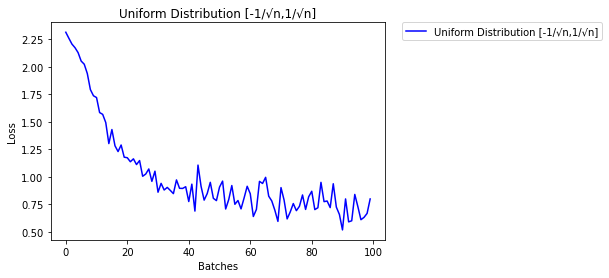

After 2 Epochs:
Validation Accuracy
   85.750% -- Uniform Distribution [-1/√n,1/√n]
Training Loss
    0.502  -- Uniform Distribution [-1/√n,1/√n]


In [12]:
compare_init_weights([(weight_updater(model_func(),5), 'Uniform Distribution [-1/√n,1/√n]')],
                     'Uniform Distribution [-1/√n,1/√n]',
                     train_loader,
                     valid_loader)

### Model 6 - Normal Distribution [-1/√n,1/√n]

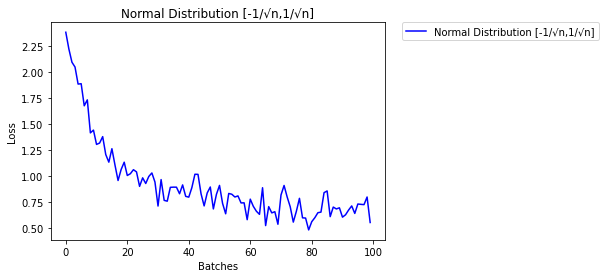

After 2 Epochs:
Validation Accuracy
   85.058% -- Normal Distribution [-1/√n,1/√n]
Training Loss
    0.471  -- Normal Distribution [-1/√n,1/√n]


In [13]:
compare_init_weights([(weight_updater(model_func(),6), 'Normal Distribution [-1/√n,1/√n]')],
                     'Normal Distribution [-1/√n,1/√n]',
                     train_loader,
                     valid_loader)

### Model 7 - Auto Initialization

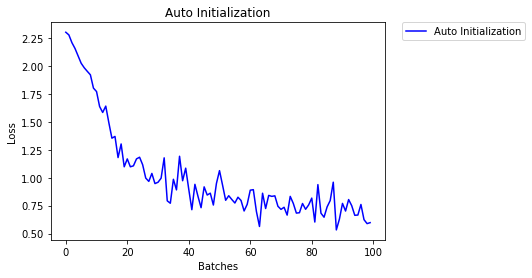

After 2 Epochs:
Validation Accuracy
   85.333% -- Auto Initialization
Training Loss
    0.382  -- Auto Initialization


In [14]:
compare_init_weights([(model_func(), 'Auto Initialization')],
                     'Auto Initialization',
                     train_loader,
                     valid_loader)

# Comparing all models

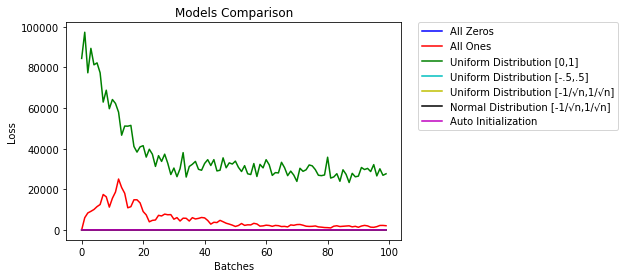

After 2 Epochs:
Validation Accuracy
    9.600% -- All Zeros
   10.275% -- All Ones
   31.208% -- Uniform Distribution [0,1]
   76.475% -- Uniform Distribution [-.5,.5]
   85.100% -- Uniform Distribution [-1/√n,1/√n]
   85.442% -- Normal Distribution [-1/√n,1/√n]
   85.350% -- Auto Initialization
Training Loss
    2.302  -- All Zeros
  626.877  -- All Ones
   10.699  -- Uniform Distribution [0,1]
    0.577  -- Uniform Distribution [-.5,.5]
    0.346  -- Uniform Distribution [-1/√n,1/√n]
    0.453  -- Normal Distribution [-1/√n,1/√n]
    0.393  -- Auto Initialization


In [15]:
model_list = [(weight_updater(model_func(),1), 'All Zeros'),
              (weight_updater(model_func(),2), 'All Ones'),
              (weight_updater(model_func(),3), 'Uniform Distribution [0,1]'),
              (weight_updater(model_func(),4), 'Uniform Distribution [-.5,.5]'),
              (weight_updater(model_func(),5), 'Uniform Distribution [-1/√n,1/√n]'),
              (weight_updater(model_func(),6), 'Normal Distribution [-1/√n,1/√n]'),
              (model_func(), 'Auto Initialization')]

compare_init_weights(model_list,
                     'Models Comparison',
                     train_loader,
                     valid_loader)

### Default initialization

Something really interesting is happening here. We may notice that the Auto Initialization "no weights" looks a lot like  uniformly initialized weights. It turns out that PyTorch has default weight initialization behavior for every kind of layer. We can see that **linear layers are initialized with a uniform distribution** (uniform weights _and_ biases) in [the module source code](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html).

---

However, we can also see that the weights taken from a normal distribution are comparable, perhaps even a little better! So, it may still be useful, especially to train the best models, to initialize the weights of a model according to rules that *we* define.

Different types of common initialization distributions can be found [here](https://pytorch.org/docs/stable/nn.html#torch-nn-init).